In [1]:
from data import read_preprocessed_data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from inertia import calculate_inertias

color_palette = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]

data_scaled = read_preprocessed_data(he=True, le=False)

/home/milosz/Desktop/code/customer-profile-analysis/data/marketing_campaign.csv


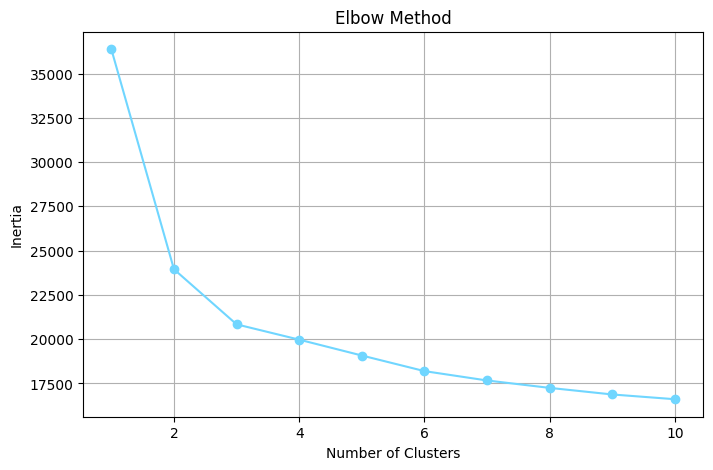

In [2]:
# Liczymy bezwładność klastrów (sumę kwadratów odległości od centroidów)
inertias = calculate_inertias(data_scaled)

# Szukamy "łokcia" na wykresie
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertias, marker="o", color=color_palette[0])
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)

Text(0.5, 1.0, 'Metoda k-średnich z wizualizacją PCA')

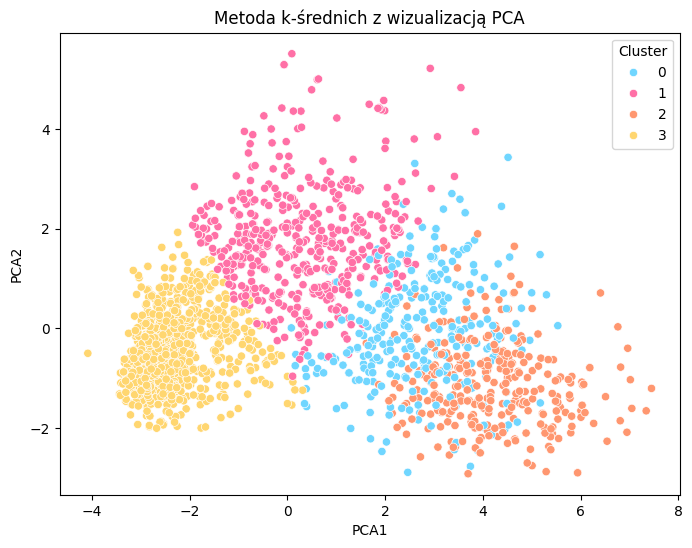

In [3]:
# Stosujemy metodę k-średnich dla wybranej liczby klastrów
optimal_k = 4

# Używamy random_state = 42, aby zapewnić, że klastry będą takie same z każdym uruchomieniem
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data_scaled["Cluster"] = kmeans.fit_predict(data_scaled)

# Dwuwymiarowa wizualizacja danych za pomocą analizy głównych składowych (PCA)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_scaled.drop("Cluster", axis=1))
data_scaled["PCA1"] = pca_components[:, 0]
data_scaled["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_scaled, x="PCA1", y="PCA2", hue="Cluster", palette=color_palette
)
plt.title("Metoda k-średnich z wizualizacją PCA")

In [4]:
#wariancja wyjaśniona przez PCA1 oraz PCA2
print("PCA1: ", round(pca.explained_variance_ratio_[0], 2))
print("PCA2: ", round(pca.explained_variance_ratio_[1], 2))
#część całkowitej wariancji danych jaką udało się przedstawić na wykresie
print("Suma wyjaśnionej wariancji: ", round(pca.explained_variance_ratio_.sum(), 2))

PCA1:  0.43
PCA2:  0.1
Suma wyjaśnionej wariancji:  0.53


In [5]:
# Wczytujemy nieustandaryzowane dane
original_data = read_preprocessed_data(std=False, le=False)

# Kopiujemy kolumnę "Cluster"
original_data["Cluster"] = data_scaled["Cluster"]

# Obliczamy średnie dla danych numerycznych i grupujemy dane według klastrów
cluster_summary = original_data.groupby("Cluster").mean(numeric_only=True)

# Obliczamy mediany dla danych kategorycznych
object_cols = original_data.select_dtypes(include="object").columns
for col in object_cols:
    mode_per_cluster = original_data.groupby("Cluster")[col].agg(lambda x: x.mode()[0])
    cluster_summary[col + "_mode"] = mode_per_cluster

# Zliczamy ilość danych w klastrze
cluster_summary["Count"] = original_data["Cluster"].value_counts().sort_index()

# Podsumowanie klastrów
cluster_summary.transpose()

/home/milosz/Desktop/code/customer-profile-analysis/data/marketing_campaign.csv


Cluster,0,1,2,3
Income,67419.1125,56115.767821,78506.347692,34595.371257
Kidhome,0.1,0.319756,0.021538,0.771457
Teenhome,0.540625,0.92057,0.055385,0.4501
Recency,47.7875,47.02444,51.975385,49.4501
MntWines,422.68125,454.462322,667.378462,39.573852
MntFruits,68.019988,13.934827,63.541144,5.020958
MntMeatProducts,239.984375,117.657841,551.510967,22.187625
MntFishProducts,90.223151,18.702648,102.004748,7.552894
MntSweetProducts,67.194142,13.764246,68.039509,5.194611
MntGoldProds,80.803111,54.835148,72.243607,14.981038


/home/milosz/Desktop/code/customer-profile-analysis/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


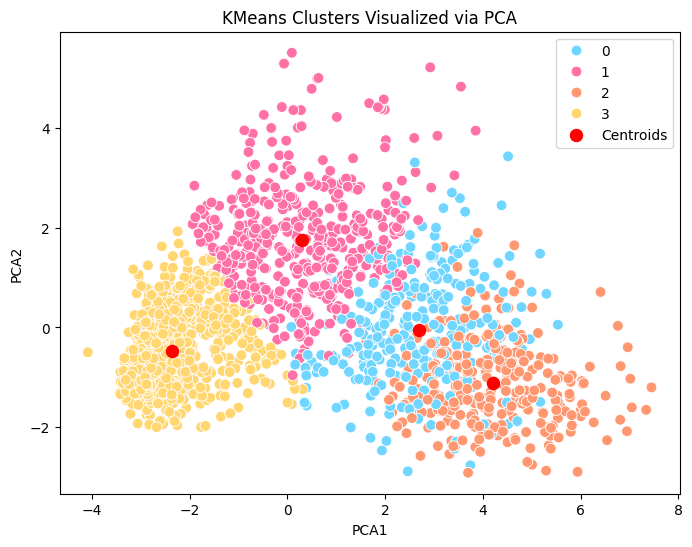

In [6]:
# Dodajemy centroidy do wykresu
centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_scaled, x="PCA1", y="PCA2", hue="Cluster", palette=color_palette, s=60
)
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    marker="o",
    s=75,
    color="red",
    label="Centroids",
)
plt.title("KMeans Clusters Visualized via PCA")
plt.legend()

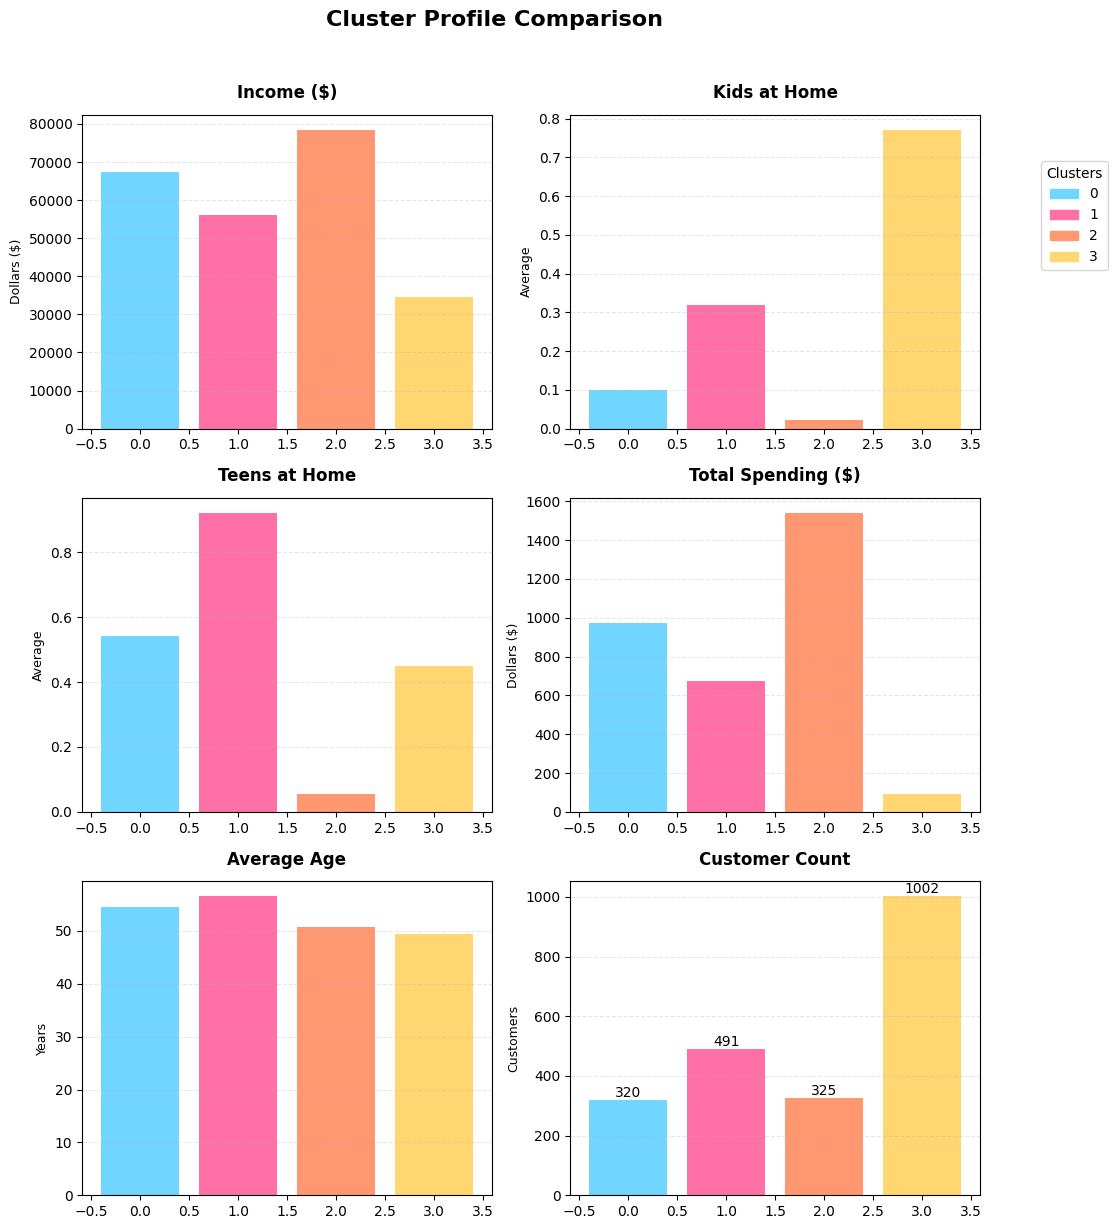

In [7]:
# Data preparation
variables = ['Income', 'Kidhome', 'Teenhome', 'Spent', 'Age', 'Count']
titles = ['Income ($)', 'Kids at Home', 'Teens at Home', 'Total Spending ($)', 'Average Age', 'Customer Count']
cluster_labels = cluster_summary.index

# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
fig.suptitle('Cluster Profile Comparison', fontsize=16, y=1.02, weight='bold')

# Plot each variable
for ax, var, title in zip(axes.flatten(), variables, titles):
    values = cluster_summary[var]
    
    bars = ax.bar(cluster_labels, values, color=color_palette)
    ax.set_title(title, pad=12, weight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add value labels for Count
    if var == 'Count':
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=10)
    
    # Format y-axis for monetary values
    if var in ['Income', 'Spent']:
        ax.set_ylabel('Dollars ($)', fontsize=9)
    elif var == 'Age':
        ax.set_ylabel('Years', fontsize=9)
    elif var == 'Count':
        ax.set_ylabel('Customers', fontsize=9)
    else:
        ax.set_ylabel('Average', fontsize=9)

plt.tight_layout()

# Add legend once
handles = [plt.Rectangle((0,0),1,1, color=color) 
           for color in color_palette]
fig.legend(handles, cluster_labels, 
           title='Clusters', 
           loc='upper right', 
           bbox_to_anchor=(1.12, 0.9))

plt.show()